In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pydot
from sklearn import tree

%matplotlib inline

In [2]:
df_all = pd.read_csv("data.csv")
df=df_all[df_all['Symbol']=='AAPL'].drop('Date', axis=1).drop('Symbol', axis=1) #sp500 only choose Apple company.

X = df.drop('Label', axis=1)
y = df['Label']

In [3]:
df.head()

,Open,High,Low,Close,Volume,Label
0,30.49,30.64,30.34,30.57,123432050,0
1,30.66,30.80,30.46,30.63,150476004,1
2,30.63,30.75,30.11,30.14,138039594,1
3,30.25,30.29,29.86,30.08,119282324,0
4,30.04,30.29,29.87,30.28,111969081,1


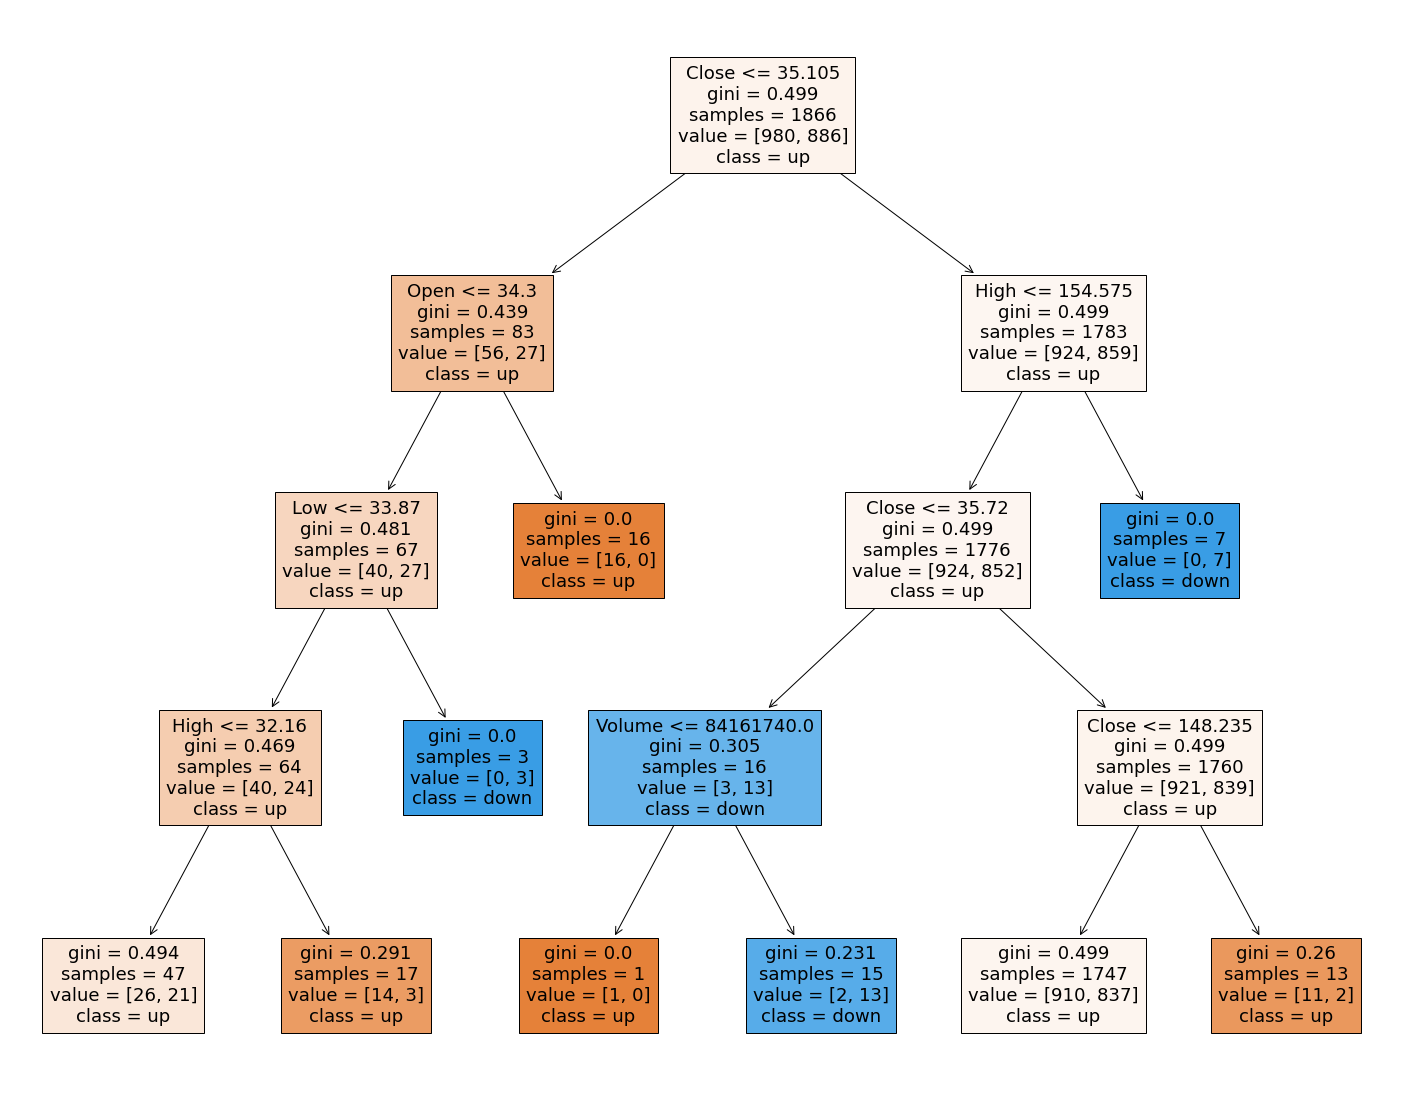

In [4]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0, max_depth = 4)
clf.fit(X, y)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=df.columns,  
                   class_names=["up", "down"],
                   filled=True)
fig.savefig("Decision Tree.png", transparent=True)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.33, # ratio of data that is used for testing
    random_state=42,
    stratify = y # Keeps the ratio of the labels in train and test the same as in the initial data
)

In [6]:
import math
n_feature = len(df.columns)
rf = RandomForestClassifier(
    max_features=math.ceil(n_feature**0.5), # Number of randomly picked features for split 
    random_state=42, # Seed for random number generator
    oob_score=True, # Out of Bag accuracy score
    bootstrap=True # 
)
param_grid = {
    'max_depth': np.arange(3,7, 1),
    'n_estimators': [50, 100, 150, 200, 250],
    'max_features': np.arange(3,n_feature,3)
}
grid_search = GridSearchCV(
    estimator=rf, # RandomForestClassifier to be optimized
    param_grid=param_grid, # parameter grid
    cv=4, # cross validation split
    n_jobs=-1, # setting for parallization, -1: use all processors
    verbose=1,
    refit=True # Refit estimator using best found parameters
)
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_features=3, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': array([3, 4, 5, 6]),
                         'max_features': array([3]),
                         'n_estimators': [50, 100, 150, 200, 250]},
             verbose=1)

In [7]:
print(grid_search.best_params_)

{'max_depth': 4, 'max_features': 3, 'n_estimators': 250}


In [8]:
rf_ = grid_search.best_estimator_
print('The train accuracy: %.4f'%rf_.score(X_train,y_train))
print('The test accuracy: %.4f'%rf_.score(X_test,y_test))
pd.DataFrame(confusion_matrix(y_test, rf_.predict(X_test)), 
             index=["solvent", "not solvent"], columns=["solvent", "not solvent"])

The train accuracy: 0.6224
The test accuracy: 0.5227


,solvent,not solvent
solvent,227,97
not solvent,197,95


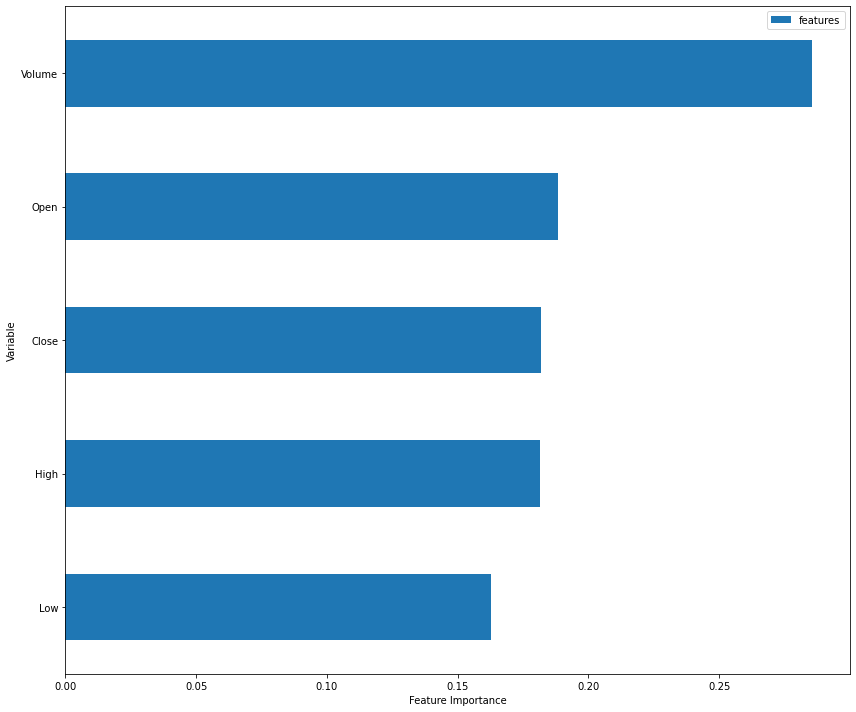

In [9]:
feature_imp = pd.DataFrame(rf_.feature_importances_,index=df.columns[:-1],columns=['features']).sort_values('features')
ax = feature_imp.plot(kind='barh', figsize=(12, 10), zorder=2)
plt.xlabel('Feature Importance')
plt.ylabel('Variable')
plt.tight_layout()
plt.savefig('RF_feature_importance.png', dpi=600, transparent=True)

Plot ROC Curves for Probit, CART, Random Forest

In [10]:
y_score = rf_.fit(X_train, y_train).predict_proba(X_test)

In [11]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test, y_score[:,1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

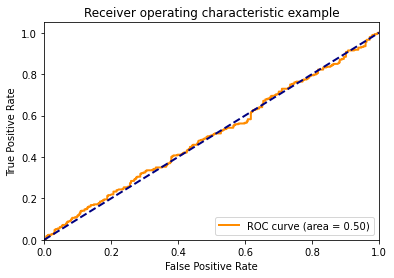

In [12]:
plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.savefig("ROC_Random Forest.png", transparent=True)

In [13]:
y_score_clf = clf.fit(X_train, y_train).predict_proba(X_test)

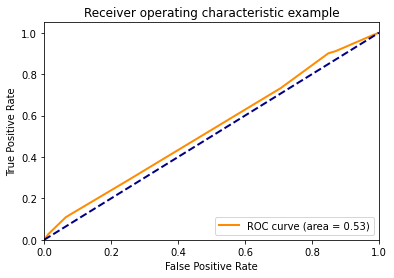

In [14]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score_clf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test, y_score_clf[:, 1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.savefig("ROC_Decision Tree.png", transparent=True)